In [1]:
#참고 사이트 :https://github.com/YBIGTA/data-science-2018/blob/master/DLCV/2018-02-10-Keras-U-Net-starter.md

import os
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Conv2D, Lambda, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow.keras.backend as K

In [2]:
"""Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR 해결 책."""
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
#gpu 메모리 할당 문제....

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './data/data-science-bowl-2018/stage1_train/'
TEST_PATH = './data/data-science-bowl-2018/stage1_test/'


In [4]:
#Get train and test IDs --> 폴더명을 가져옴.
train_ids = next(os.walk(TRAIN_PATH))[1] #return type : list
test_ids = next(os.walk(TEST_PATH))[1]

print("train_ids 길이 : ", len(train_ids))
print("test_ids 길 : ", len(test_ids))

train_ids 길이 :  670
test_ids 길 :  65


In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
#sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')


  0%|          | 0/670 [00:00<?, ?it/s]

Getting and resizing train images and masks ... 


 14%|█▍        | 9/65 [00:00<00:00, 76.66it/s]

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 78.61it/s]

Done!


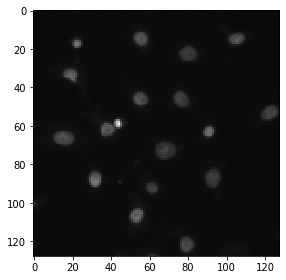

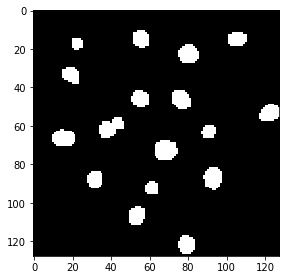

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

##### 궁금한 점
- imshow(np.squeeze(train_labels[ix])) 로 하면 오류가 안생기는데 imshow(train_labels[ix])를 하면 오류가 생길까?
- 그리고 np.squeeze를 하면 (128 128 1 ) 이런식으로 , 가 없어지는데 이건  없어지는거지?
- train_images에서는 np.squeeze를 하든 말든 잘 출력이 되는데 이건 또 왜 그러는걸까

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
print(s)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

W0903 14:09:10.829131 140002402735936 deprecation.py:506] From /home/mulkong/anaconda3/envs/mulkong/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Tensor("lambda/truediv:0", shape=(?, 128, 128, 3), dtype=float32)


W0903 14:09:11.116014 140002402735936 deprecation.py:323] From <ipython-input-7-06be6bdbb4c6>:5: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0903 14:09:11.171065 140002402735936 deprecation.py:323] From /home/mulkong/anaconda3/envs/mulkong/lib/python3.7/site-packages/tensorflow/python/ops/metrics_impl.py:1178: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0903 14:09:11.172335 140002402735936 deprecation.py:323] From /home/mulkong/anaconda3/envs/mulkong/lib/python3.7/site-packages/tensorflow/python/ops/metrics_impl.py:1179: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
from sklearn.model_selection import train_test_split

train_images,valid_images,train_labels, valid_labels = train_test_split(X_train, Y_train, test_size=0.1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=10000).batch(16)
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).shuffle(buffer_size = 10000).batch(16)

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(train_dataset, validation_data=validation_dataset,  epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 0.3564 - mean_iou: 0.4423
Epoch 00001: val_loss improved from inf to 0.20782, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 6s 169ms/step - loss: 0.3546 - mean_iou: 0.4448 - val_loss: 0.2078 - val_mean_iou: 0.5487
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.1868 - mean_iou: 0.5998
Epoch 00002: val_loss improved from 0.20782 to 0.13894, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 1s 35ms/step - loss: 0.1855 - mean_iou: 0.6008 - val_loss: 0.1389 - val_mean_iou: 0.6429
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.1570 - mean_iou: 0.6671
Epoch 00003: val_loss improved from 0.13894 to 0.13684, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 1s 34ms/step - loss: 0.1554 - mean_iou: 0.6675 - val_loss: 0.1368 - val_mean_iou: 0.6877
Epoch 4/50
37/38 [============================>.]

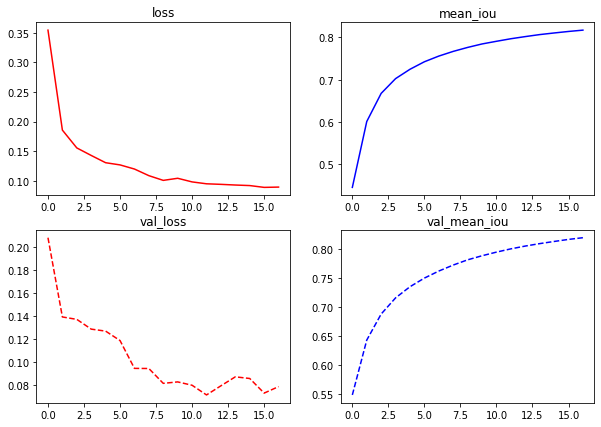

In [11]:

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(results.history['loss'], 'r')
ax[0, 1].set_title('mean_iou')
ax[0, 1].plot(results.history['mean_iou'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(results.history['val_loss'], 'r--')
ax[1, 1].set_title('val_mean_iou')
ax[1, 1].plot(results.history['val_mean_iou'], 'b--')

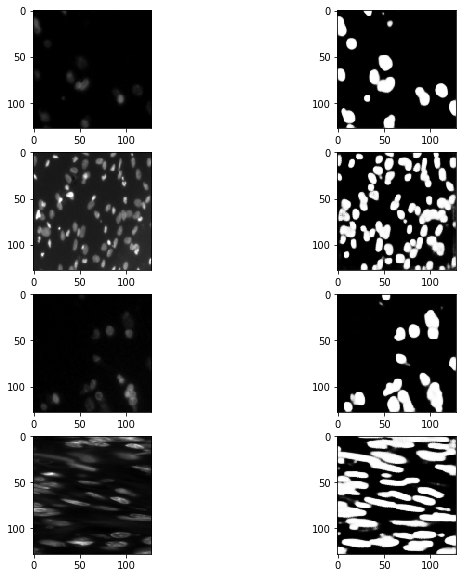

In [18]:
preds = model.predict(X_test)

fig, ax = plt.subplots(4, 2, figsize=(10, 10))


for i, pred in enumerate(preds):
    ax[i, 0].imshow(X_test[i].squeeze())
    #ax[i, 1].imshow(test_labels[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')
    if i == 3:
        break